# Part 2: Resolution

In [1]:
# IPython magics
%matplotlib inline

In [2]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage



## Maxwell-Boltzmann distribution
Measurement of 1D particle energy distributions. The canonical Maxwell-Boltzmann distribution
is given by:

\\( f(v) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{mv^2}{2k_BT}\right) \\)

where m is the mass of the species, n is the (number) density, k<sub>B</sub>T is the temperature, and v is the speed at which we are looking for the distribution function. Here we will use a "drifting Maxwellian" which is a Maxwell-Boltzmann distribution that is moving at a relative velocity to the frame of the distribution.

\\( f(\mathbf{v}) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{m(\mathbf{v_0}-\mathbf{v})^2}{2k_BT}\right) \\)

We also need to convert the distribution function to units of differential number flux, also known as DNF [m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>], and differential energy flux, also known as DEF [J m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>]. Note that the "J/J" part of the DEF units is retained to indicate DEF and to avoid ambiguity.

\\( J_N = f\frac{v^2}{m} \\)  
\\( J_E = f\frac{v^4}{2m} \\)

In our code we will implement the drifting Maxwellian and conversions as a Python lambda functions.

In [3]:
# Distribution function for a drifting isotropic Maxwell-Boltzmann distribution with density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_mb(m, q, n, v0, th0, ph0, kT, EperQ, th, ph):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
#x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    return n*((m*consts.u/(2*np.pi*kT*consts.e))**(1.5))*np.exp(-x/(kT*consts.e))

# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
todnf = lambda f, EperQ, m, q: f*EperQ*consts.e*2*(q/(m*consts.u))**2
todef = lambda f, EperQ, m, q: f*((EperQ*consts.e)**2)*q*2*(q/(m*consts.u))**2

Generate a solar wind spectrum with H+ and He++ moving at 450 km/s with a temperature of 10 eV.

Text(0,0.5,'Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

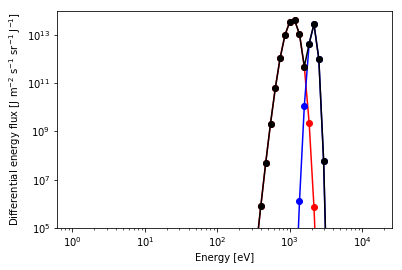

In [4]:
E = np.logspace(0,4.2,64) # in eV/q
f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, E, 0.0, 0.0)
f_he = dist_mb(4.00260325415, 2.0, 1e6*0.04, 450.0,0.0,0.0, 10.0, E, 0.0, 0.0)
plt.loglog(E, todef(f_h,E,1.007825032241,1.0),'or')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0),'-r')
plt.loglog(E,todef(f_he,E,4.00260325415,2.0),'ob')
plt.loglog(E,todef(f_he,E,4.00260325415,2.0),'-b')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0)+todef(f_he,E,4.00260325415,2.0),'ok')
plt.loglog(E, todef(f_h,E,1.007825032241,1.0)+todef(f_he,E,4.00260325415,2.0),'-k')
plt.xlabel('Energy [eV]')
plt.ylim([1e5,1e14])
plt.ylabel('Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

Here the speed of the solar wind, combined with the low temperature produces a very narrow beam in energy. To properly forward-model this we need to account for the finite width of each energy bin.

In [5]:
# Define some parameters of the energy table and geometric/calibration factor.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0

G = 5e-10
quantumeff = lambda E, scale=10000: np.exp(-(E/10000)**2)

Now lets look at the counts across a single energy/charge bin.

3277.026996127254
3277.026996127254


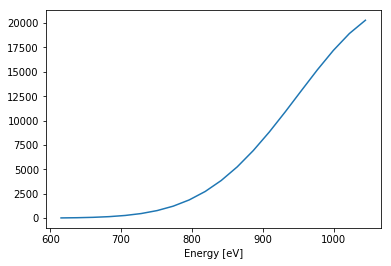

In [6]:
# Bin number, and now many sub-samples to take
i = 40
n = 20

# Instrument response is modelled as a Gaussian.
fwhm = energy_table_upper[i]-energy_table_lower[i]
sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
tmp_energies = np.linspace(energy_table_lower[i]*(1-energy_resolution),energy_table_upper[i]*(1+energy_resolution),n)
eps = quantumeff(tmp_energies)
de_tmp_energies = (np.max(tmp_energies)-np.min(tmp_energies))/n
f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, tmp_energies, 0.0, 0.0)
inst_response = np.exp(-0.5*((tmp_energies-energy_table_centre[i])/sig)**2)/(sig*np.sqrt(2*np.pi))

print(np.sum(inst_response*todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps*de_tmp_energies))

plt.plot(tmp_energies, todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps)
plt.xlabel('Energy [eV]')

# This function returns the counts in a single bin for an under-resolved population.
def underresolve(fun, E_low, E_up, E_c, dEoverE, n=20):
    fwhm = E_up-E_low
    sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
    tmp_energies = np.linspace(E_low*(1-dEoverE), E_up*(1+dEoverE), n)
    de_tmp_energies = (E_up*(1+dEoverE)-E_low*(1-dEoverE))/n
    inst_response = np.exp(-0.5*((tmp_energies-E_c)/sig)**2)/(sig*np.sqrt(2*np.pi))
    return np.sum(inst_response*fun(tmp_energies)*de_tmp_energies)

# Check.
print(underresolve(lambda E: todef(f_h,E,1.007825032241,1.0)*G*eps, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution))


## Synthetic under-resolved spectrum
Finally, we can fully sample the analytic spectrum, taking into account the sub-optimal resolution.

Text(0,0.5,'Counts/accumulation')

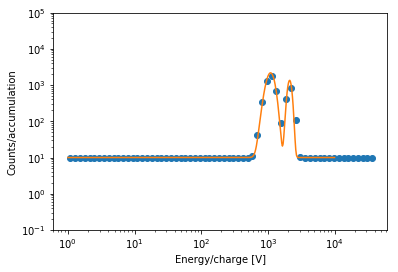

In [8]:
# Instrument parameters.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0

# Calculate the counts

C = np.zeros(num_energy_bins)
deffun = lambda E: (todef(dist_mb(1.007825032241, 1.0, 1e5*(1-0.04), 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,1.007825032241,1.0) +
                        todef(dist_mb(4.00260325415, 2.0, 1e5*0.04, 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)+10.0
for i in range(num_energy_bins):
    C[i] = underresolve(deffun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)

# Generate a high resolution spectrum for comparison
E_hi = np.logspace(0,4,400)
def_hi = deffun(E_hi)
    
plt.loglog(energy_table_centre,C,'o')
plt.loglog(E_hi,def_hi)
plt.ylim([1e-1,1e5])
plt.xlabel('Energy/charge [V]')
plt.ylabel('Counts/accumulation')

## Let's try to fit this - using all the ingredients but using a different fitting method

Step: n_h=100000.0 n_he=10000.0 v=420.0 kT=10.0
Step: n_h=100000.0 n_he=10000.0 v=420.0 kT=10.0
Step: n_h=108437.5 n_he=9468.75 v=433.75 kT=9.4375
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=101015.625 n_he=10070.3125 v=459.0625 kT=9.015625
Step: n_h=104030.38024902344 n_he=9432.121276855469 v=471.41937255859375 kT=8.679794311523438
Step: n_h=104030.38024902344 n_he=9432.121276855469 v=471.41937255859375 kT=8.679794311523438
Step: n_h=105857.53202438354 n_he=10361.778020858765 v=460.0947093963623 kT=8.30653715133667
Step: n_h=105857.53202438354 n_he=10361.778020858765 v=460.0947093963623 kT=8.30653715133667
Step: n_h=105857.53202438354 n_he=10361.778020858765 v=460.0947093963623 kT=8.30653715133667
Step: n_h=107998.830825090

/home/edas2018/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/edas2018/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Step: n_h=122909.59530649375 n_he=14978.270948275664 v=444.3683069555658 kT=1.5431693346821191
Step: n_h=122909.59530649375 n_he=14978.270948275664 v=444.3683069555658 kT=1.5431693346821191
Step: n_h=122909.59530649375 n_he=14978.270948275664 v=444.3683069555658 kT=1.5431693346821191
Step: n_h=122909.59530649375 n_he=14978.270948275664 v=444.3683069555658 kT=1.5431693346821191
Step: n_h=122909.59530649375 n_he=14978.270948275664 v=444.3683069555658 kT=1.5431693346821191
Step: n_h=121683.0348456722 n_he=14925.64512845843 v=448.04377155025816 kT=1.4763752056214297
Step: n_h=121683.0348456722 n_he=14925.64512845843 v=448.04377155025816 kT=1.4763752056214297
Step: n_h=122529.14368483532 n_he=15000.434858250374 v=447.47985030110306 kT=1.3426797439656282
Step: n_h=122529.14368483532 n_he=15000.434858250374 v=447.47985030110306 kT=1.3426797439656282
Step: n_h=122529.14368483532 n_he=15000.434858250374 v=447.47985030110306 kT=1.3426797439656282
Step: n_h=122529.14368483532 n_he=15000.434858250

Step: n_h=252134.26986199745 n_he=11255.205797797295 v=450.81541266814634 kT=2.084694269767933
Step: n_h=252134.26986199745 n_he=11255.205797797295 v=450.81541266814634 kT=2.084694269767933
Step: n_h=253300.89447394735 n_he=11224.70232997166 v=450.81832051306196 kT=2.0914782793111995
Step: n_h=252681.40710250894 n_he=11242.281624503848 v=450.81160240190775 kT=2.089855490930254
Step: n_h=252681.40710250894 n_he=11242.281624503848 v=450.81160240190775 kT=2.089855490930254
Step: n_h=252470.97377320024 n_he=11252.336206556498 v=450.8159915321281 kT=2.0859819480373503
Step: n_h=252470.97377320024 n_he=11252.336206556498 v=450.8159915321281 kT=2.0859819480373503
Step: n_h=252197.48017874872 n_he=11261.701064410168 v=450.83455570297497 kT=2.087901762020225
Step: n_h=252220.0939912331 n_he=11267.421960614196 v=450.7874976213923 kT=2.0868217436530108
Step: n_h=252494.77514873794 n_he=11267.139099723383 v=450.8259348757813 kT=2.0866266502471404
Step: n_h=252494.77514873794 n_he=11267.13909972338

Step: n_h=1184098.5362265436 n_he=57466.43929698675 v=450.228414836552 kT=8.803544579891472
Step: n_h=1184098.5362265436 n_he=57466.43929698675 v=450.228414836552 kT=8.803544579891472
Step: n_h=1071855.174475911 n_he=48079.957062867325 v=450.6777845317688 kT=7.861479608381565
Step: n_h=1071855.174475911 n_he=48079.957062867325 v=450.6777845317688 kT=7.861479608381565
Step: n_h=1181447.6045674835 n_he=56102.61886780933 v=450.8698167326246 kT=8.56992394691251
Step: n_h=1181447.6045674835 n_he=56102.61886780933 v=450.8698167326246 kT=8.56992394691251
Step: n_h=1181447.6045674835 n_he=56102.61886780933 v=450.8698167326246 kT=8.56992394691251
Step: n_h=1133872.874188045 n_he=49618.80727902225 v=450.0372223076896 kT=8.013171052545342
Step: n_h=1206801.8541693497 n_he=59224.0673526013 v=450.21961324653523 kT=8.481298530566779
Step: n_h=1139504.8827906707 n_he=51112.18009019962 v=451.25506197224956 kT=8.020004005709017
Step: n_h=1250522.0779489581 n_he=56344.799445090335 v=450.13786223280385 k

Step: n_h=1581576.7528773746 n_he=66309.7059725635 v=449.89218679013567 kT=10.184758491580899
Step: n_h=1581561.999845496 n_he=66308.80643413504 v=449.8922010474179 kT=10.184672937483883
Step: n_h=1581561.999845496 n_he=66308.80643413504 v=449.8922010474179 kT=10.184672937483883
Step: n_h=1581562.1902742651 n_he=66308.60265091855 v=449.89228090127966 kT=10.18469740673051
Step: n_h=1581562.1902742651 n_he=66308.60265091855 v=449.89228090127966 kT=10.18469740673051
Step: n_h=1581562.1902742651 n_he=66308.60265091855 v=449.89228090127966 kT=10.18469740673051
Step: n_h=1581562.1902742651 n_he=66308.60265091855 v=449.89228090127966 kT=10.18469740673051
Step: n_h=1581567.6007229045 n_he=66308.92617558203 v=449.89221927912456 kT=10.184728633499066
Step: n_h=1581567.6007229045 n_he=66308.92617558203 v=449.89221927912456 kT=10.184728633499066
Step: n_h=1581565.8010437433 n_he=66308.96444561421 v=449.89222425371895 kT=10.1847108132946
Step: n_h=1581565.8010437433 n_he=66308.96444561421 v=449.892

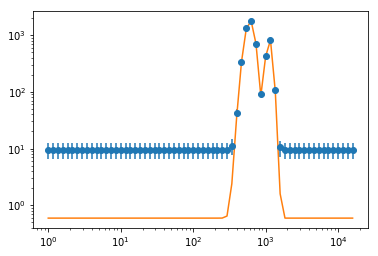

In [10]:
# Function to calculate a spectrum given the parameters in the matrix p
def spec(p):
    tmpfun = lambda E: (todef(dist_mb(1.007825032241, 1.0, p[0], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,1.007825032241,1.0) +
         todef(dist_mb(4.00260325415, 2.0, p[1], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)+10.0

    f = np.zeros(num_energy_bins)
    for i in range(num_energy_bins):
        f[i] = underresolve(tmpfun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)

    return f*4/64

# Calculate the cost function.
def fitfun(p):
    return np.sqrt(np.sum((spec(p)-C)**2))

# Perform the fit. Notice this is iterative.
p = scipy.optimize.fmin(fitfun, [1e5,1e4,400,10], disp=True, callback=lambda p: print('Step: n_h={} n_he={} v={} kT={}'.format(p[0],p[1],p[2],p[3])))

plt.errorbar(E,C,yerr=np.sqrt(C),fmt='o')
#plt.loglog(E,f*taua)
plt.loglog(E,spec(p))

print(p)

## Explore the chi-square space in the dimension of velocity and temperature

In [ ]:
x = np.linspace(250,650,80)
y = np.linspace(2,42,40)
rms = np.zeros((80,40))
for iy in range(40):
    print('{}/{}'.format(iy+1,40))
    for ix in range(80):
        rms[ix,iy] = fitfun([p[0],p[1],x[ix],y[iy]])
plt.pcolor(x,y,np.log10(rms.T))
plt.colorbar()